# AB test calculator

Using frequentist methods.

We'll build it out as though you only have to enter sessions and conversions as numbers -
in theory the most simple version of a test calculator.

In [23]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go

from generate_data import *
from plot import *
from stats import *

roboto = {'fontname': 'Roboto', 'size': '12'}
roboto_bold = {'fontname': 'Roboto', 'size': '14', 'weight': 'bold'}
roboto_small = {'fontname': 'Roboto', 'size': '7.5', 'weight': 'light'}

In [5]:
def z_test(control_observations,control_conversions,variant_observations,variant_conversions, one_tail=False):
    """ Run a Z-test with your data, returning the Z-score and p-value.

    Parameters
    ---------
    control_observations, variant_observations : int
        Number of sessions/users

    control_conversions, variant_conversions : int
        Number of conversions

    one_tail : [False, 'left', 'right'] (optional)
        Specify what type of test; if False (default), the p-value for a two-tail
        Z-test will be returned.
        'left' specifies a one-tail Z-test where the alternative hypothesis is that
        the variant will return a better conversion rate, 'right' is the opposite.

    Returns
    -------
    z_score : float
        Number of standard deviations between the mean of the control conversion
        rate distribution and the variant conversion rate
    p_value : float
        Probability of obtaining test results at least as extreme as the observed
        results, under the conditions of the null hypothesis
    """


    # conversion rates
    control_cr = control_conversions/control_observations
    variant_cr = variant_conversions/variant_observations

    # standard errors
    control_se = (control_cr*(1-control_cr)/control_observations)**0.5
    variant_se = (variant_cr*(1-variant_cr)/variant_observations)**0.5
    
    # standard error of the difference
    se_difference = (control_se**2+variant_se**2)**0.5
    
    # z-score
    z_score = (variant_cr - control_cr)/se_difference
    
    # Calculate the p-value dependent on one or two tails
    if one_tail == 'left':
        p_value = scs.norm.cdf(-abs(z_score))
    elif one_tail == 'right':
        p_value = scs.norm.cdf(abs(z_score))
    else:
        p_value = 2*scs.norm.cdf(-abs(z_score))

    return z_score, p_value

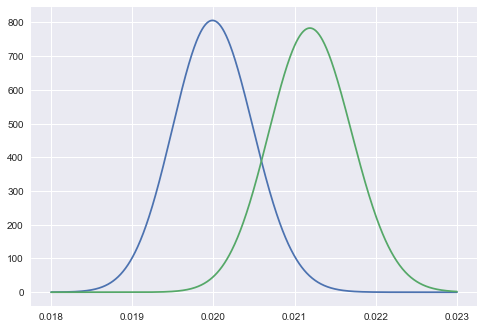

In [6]:
x = np.linspace(0.018, 0.023, 1000)
y = scs.beta(1600, 80000-1600).pdf(x)
plt.plot(x, y)
y = scs.beta(1696, 80000-1696).pdf(x)
plt.plot(x, y)

visitors_A, conversions_A = 80000, 1600
visitors_B, conversions_B = 80000, 1696

control_cr = conversions_A/visitors_A
variant_cr = conversions_B/visitors_B
relative_difference = variant_cr/control_cr - 1

control_se = (control_cr*(1-control_cr)/visitors_A)**0.5
variant_se = (variant_cr*(1-variant_cr)/visitors_B)**0.5
se_difference = (control_se**2+variant_se**2)**0.5

z_score, p_value = z_test(80000, 1600, 80000, 1696, one_tail=False)

In [7]:
data = {
    "<b>Variant</b>": ['A', 'B'],
    "<b>Visitors</b>": [f"{visitors_A:,}", f"{visitors_B:,}"],
    "<b>Conversions</b>": [conversions_A, conversions_B],
    "<b>Conversion rate</b>": [f"{control_cr:.2%}", f"{variant_cr:.2%}"],
    "<b>Uplift</b>": ['', f"{relative_difference:.2%}"],
    "<b>Z-score</b>": ["", f"{z_score:.4f}"],
    "<b>P-value</b>": ["", f"{p_value:.4f}"]
}

df = pd.DataFrame(data)
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(df.columns),
        line_color='white', fill_color='white',
        font=dict(size=12, color='black'),
        align="left",
    ),
    cells=dict(
        values=[df[k].tolist() for k in df.columns],
        align="left",
        fill=dict(color=[['#F9F9F9', '#FFFFFF']*5]),
    )
)
])

fig.update_layout(
        autosize=False,
        height=150,
        margin=dict(
            l=20,
            r=20,
            b=10,
            t=30,
        )
    )

fig.show()

In [8]:
def get_power(visitors_A, conversions_A, visitors_B, conversions_B, alpha=0.05, two_tails=True):
    """Returns observed power from test results.

    Parameters
    ---------
    visitors_A, visitors_B : int
        Number of sessions/users

    conversions_A, conversions_B : int
        Number of conversions

    alpha : float
        Default = 0.05
        Type I error level
    
    two_tails : boolean (optional)
        Default = True
        One or two-tail test

    Returns
    -------
    power
    """

    n = visitors_A + visitors_B

    control_cr = conversions_A/visitors_A
    variant_cr = conversions_B/visitors_B

    if two_tails:
        qu = scs.norm.ppf(1 - alpha/2)
    else:
        qu = scs.norm.ppf(1 - alpha)

    diff = abs(variant_cr - control_cr)
    avg_cr = (control_cr + variant_cr) / 2

    control_var = control_cr * (1 - control_cr)
    variant_var = variant_cr * (1 - variant_cr)
    avg_var = avg_cr * (1-avg_cr)

    power_lower = scs.norm.cdf(
        (n**0.5 * diff - qu * (2 * avg_var)**0.5) /
        (control_var+variant_var) ** 0.5
    )
    power_upper = 1 - scs.norm.cdf(
        (n**0.5 * diff + qu * (2 * avg_var)**0.5) /
        (control_var+variant_var) ** 0.5
    )

    power = power_lower + power_upper

    return power

In [9]:
get_power(80000, 1600, 80000, 1696, 0.05, two_tails=False)

0.7717958377897491

### Normal distribution plot

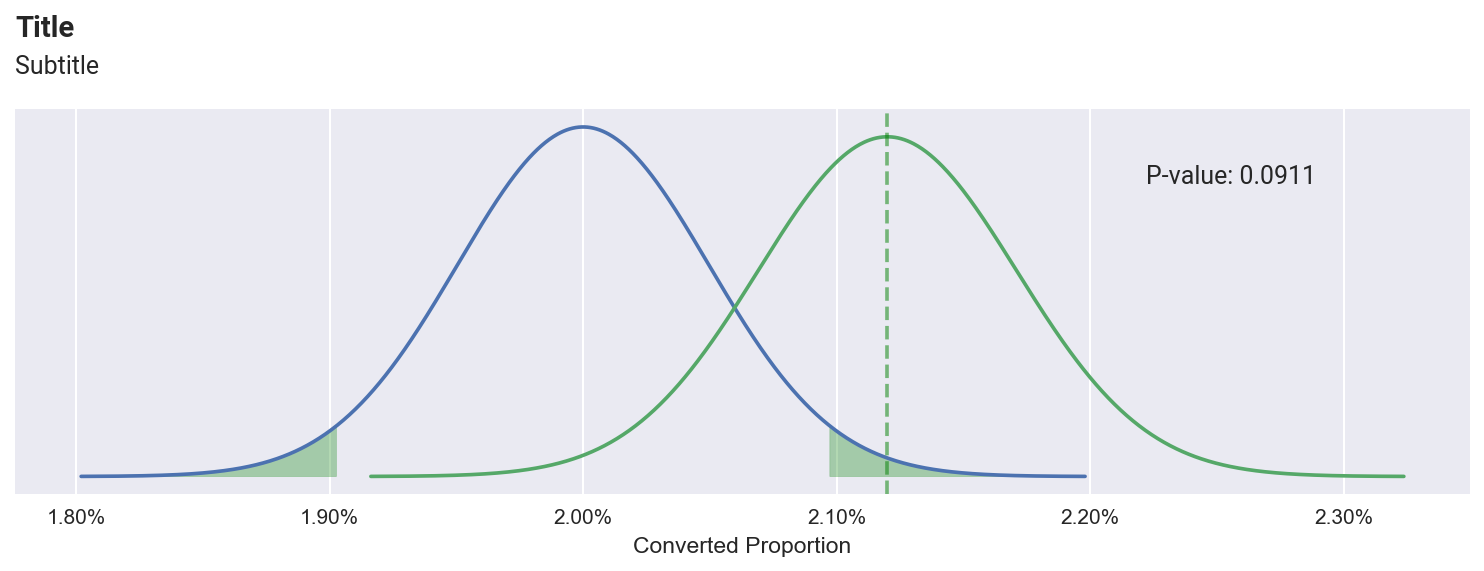

In [10]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
xA = np.linspace(control_cr-4*control_se, control_cr+4*control_se, 1000)
yA = scs.norm(control_cr, control_se).pdf(xA)
ax.plot(xA, yA)
# ax.axvline(x=control_cr, c='red', alpha=0.5, linestyle='--')
# ax.axvline(x=control_cr+control_se*1.96, c='red', alpha=0.5, linestyle='--')
# ax.axvline(x=control_cr-control_se*1.96, c='red', alpha=0.5, linestyle='--')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
xB = np.linspace(variant_cr-4*variant_se, variant_cr+4*variant_se, 1000)
yB = scs.norm(variant_cr, variant_se).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=variant_cr, c='green', alpha=0.5, linestyle='--')
# ax.axvline(x=variant_cr+variant_se*1.96, c='green', alpha=0.5, linestyle='--')
# ax.axvline(x=variant_cr-variant_se*1.96, c='green', alpha=0.5, linestyle='--')

ax.fill_between(
    xA, 0, yA,
    where=(xA > control_cr + control_se*1.96) | (xA < control_cr - control_se*1.96),
    color='green', alpha=0.3
    )

ax.text(
    np.max([control_cr+2*control_se, variant_cr+2*variant_se]),
    ax.get_ylim()[1]*0.8,
    f"P-value: {z_test(visitors_A, conversions_A, visitors_B, conversions_B)[1]:.4f}",
    horizontalalignment='left',
    **roboto
    )

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.2,
    'Title',
    **roboto_title
)

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.1,
    'Subtitle',
    **roboto
)

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

sns.despine(left=True)
ax.get_yaxis().set_visible(False)
fig.tight_layout()

plt.show()

Text(0, 0.5, 'PDF')

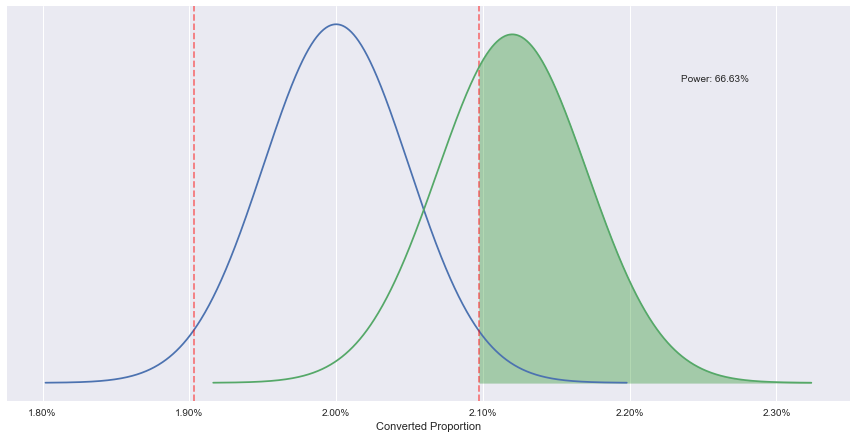

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(control_cr-4*control_se, control_cr+4*control_se, 1000)
yA = scs.norm(control_cr, control_se).pdf(xA)
ax.plot(xA, yA)
# ax.axvline(x=control_cr, c='red', alpha=0.5, linestyle='--')
ax.axvline(x=control_cr+control_se*1.96, c='red', alpha=0.5, linestyle='--')
ax.axvline(x=control_cr-control_se*1.96, c='red', alpha=0.5, linestyle='--')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
xB = np.linspace(variant_cr-4*variant_se, variant_cr+4*variant_se, 1000)
yB = scs.norm(variant_cr, variant_se).pdf(xB)
ax.plot(xB, yB)
# ax.axvline(x=variant_cr, c='green', alpha=0.5, linestyle='--')
# ax.axvline(x=variant_cr+variant_se*1.96, c='green', alpha=0.5, linestyle='--')
# ax.axvline(x=variant_cr-variant_se*1.96, c='green', alpha=0.5, linestyle='--')

ax.fill_between(
    xB, 0, yB,
    where=(xB > control_cr + control_se*1.96),
    color='green', alpha=0.3
    )

ax.text(
    ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.8,
    ax.get_ylim()[1]*0.8,
    f"Power: {get_power(visitors_A, conversions_A, visitors_B, conversions_B):.2%}",
    horizontalalignment='left'
    )
sns.despine(left=True)
ax.get_yaxis().set_visible(False)
fig.tight_layout()

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

In [12]:
confidence_interval(control_cr, control_se, visitors_A)

(0.019996570063027054, 0.020003429936972947)

In [13]:
sample_cr = (conversions_A+conversions_B)/(visitors_A+visitors_B)

z_score = (control_cr-variant_cr)/np.sqrt(sample_cr*(1-sample_cr)*(1/visitors_A+1/visitors_B))

2*scs.norm.cdf(-abs(z_score))

0.0910943167797637

## Plots

In [19]:
tails=False
alpha=0.05

if tails == 'One-tail':
    two_tails=False
    if relative_difference < 0:
        tail_direction = 'right'
    else:
        tail_direction = 'left'
else:
    two_tails=True
    tail_direction = False

z_score, p_value = z_test(visitors_A, conversions_A,
                            visitors_B, conversions_B, one_tail=tail_direction)                      

power = get_power(visitors_A, conversions_A,
                    visitors_B, conversions_B,
                    alpha=alpha, two_tails=two_tails)


frequentist_data = {
    "<b>Variant</b>": ['A', 'B'],
    "<b>Visitors</b>": [f"{visitors_A:,}", f"{visitors_B:,}"],
    "<b>Conversions</b>": [conversions_A, conversions_B],
    "<b>Conversion rate</b>": [f"{control_cr:.2%}", f"{variant_cr:.2%}"],
    "<b>Uplift</b>": ['', f"{relative_difference:.2%}"],
    "<b>Power</b>": ["", f"{power:.4f}"],
    "<b>Z-score</b>": ["", f"{z_score:.4f}"],
    "<b>P-value</b>": ["", f"{p_value:.4f}"]
}

fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(frequentist_data.keys()),
        line_color='white', fill_color='white',
        font=dict(size=12, color='black'),
        align="left",
    ),
    cells=dict(
        values=[frequentist_data.get(k) for k in frequentist_data.keys()],
        align="left",
        fill=dict(color=[['#F9F9F9', '#FFFFFF']*5]),
    )
)
])

fig.update_layout(
    autosize=False,
    height=150,
    margin=dict(
        l=20,
        r=20,
        b=10,
        t=30,
    )
)

fig.show()

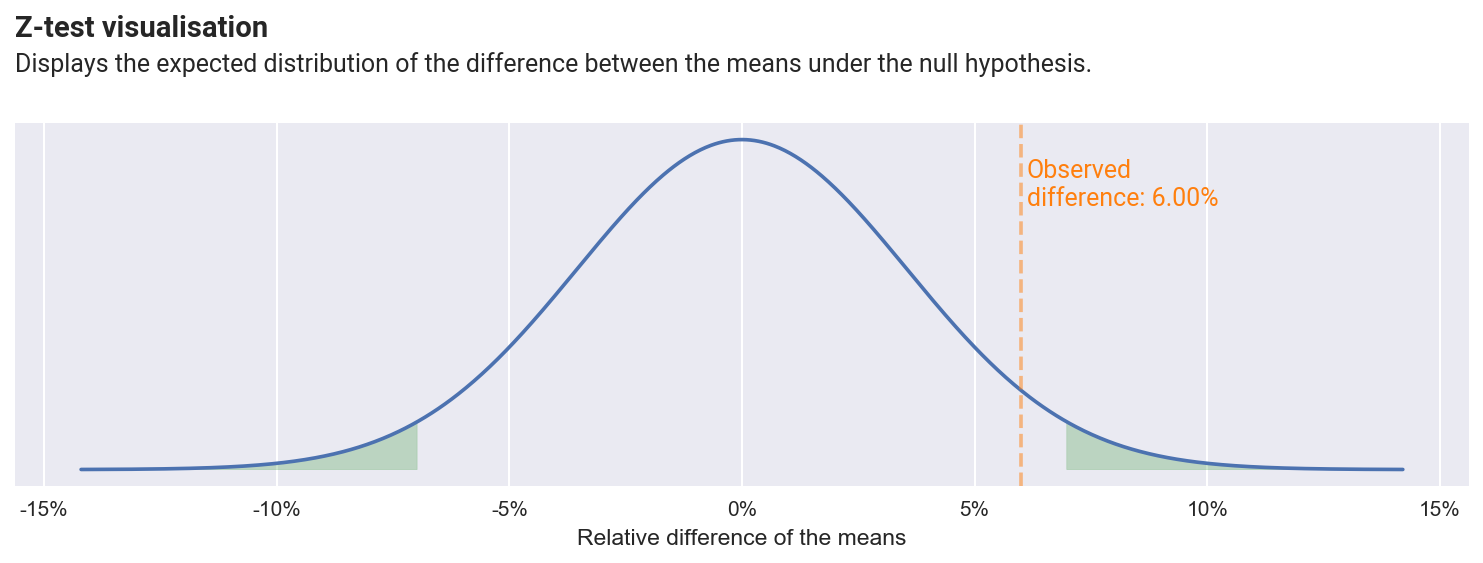

In [21]:
def get_z_value(alpha=0.05, two_tailed=True):
    z_dist = scs.norm()
    if two_tailed:
        alpha = alpha/2
        area = 1 - alpha
    else:
        area = 1 - alpha

    z = z_dist.ppf(area)
    return z


z_value_for_alpha = get_z_value(alpha=alpha, two_tailed=two_tails)

control_cr = conversions_A/visitors_A
variant_cr = conversions_B/visitors_B

# standard errors
control_se = (control_cr*(1-control_cr)/visitors_A)**0.5
variant_se = (variant_cr*(1-variant_cr)/visitors_B)**0.5

# standard error of the difference
se_difference = (control_se**2+variant_se**2)**0.5

f"""
According to the null hypothesis, there is no difference between the means.
The plot below shows the distribution of the difference of the means that we 
would expect under the null hypothesis. 
"""

# Z-test visualisation
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
xA = np.linspace(0-4*se_difference, 0+4*se_difference, 1000)
yA = scs.norm(0, se_difference).pdf(xA)
ax.plot(xA, yA)

diff = variant_cr - control_cr

ax.axvline(x=diff, ymax=ax.get_ylim()[1],
                c='tab:orange', alpha=0.5, linestyle='--')
ax.text(
    diff*1.02,
    max(yA)*0.8,
    "Observed\ndifference: {:.2%}".format(
        relative_difference),
    color='tab:orange',
    # rotation=270,
    **roboto
)

if tail_direction == 'left':
    ax.fill_between(
        xA, 0, yA,
        where=(
            xA > 0 + se_difference*z_value_for_alpha
        ),
        color='green', alpha=0.2
    )
elif tail_direction == 'right':
    ax.fill_between(
        xA, 0, yA,
        where=(
            xA < 0 - se_difference*z_value_for_alpha
        ),
        color='green', alpha=0.2
    )
else:
    ax.fill_between(
        xA, 0, yA,
        where=(
            xA > 0 + se_difference*z_value_for_alpha
        ) | (
            xA < 0 - se_difference*z_value_for_alpha
        ),
        color='green', alpha=0.2
    )

ax.get_xaxis().set_major_formatter(
    mtick.FuncFormatter(lambda x, p: format(x/control_cr, '.0%')))

# ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Relative difference of the means')
plt.ylabel('PDF')

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.25,
    'Z-test visualisation',
    **roboto_title
)

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.15,
    "Displays the expected distribution of the difference between the means under the null hypothesis.",
    **roboto
)

sns.despine(left=True)
ax.get_yaxis().set_visible(False)
fig.tight_layout()

plt.show()

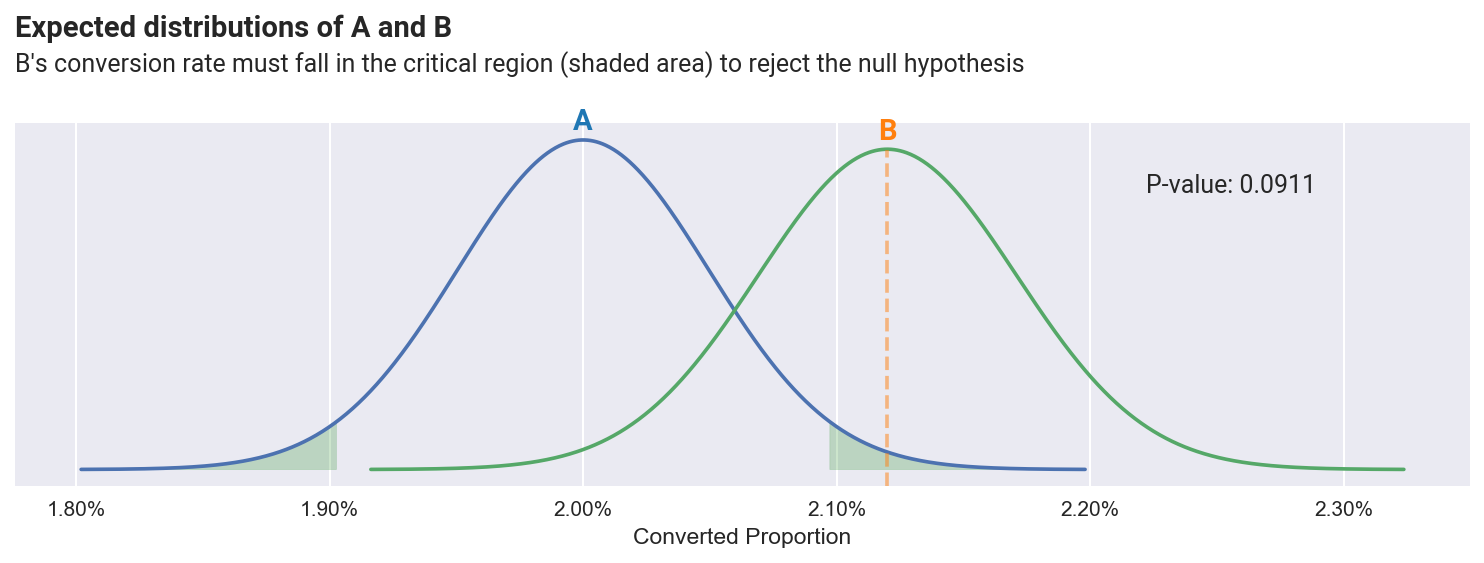

In [26]:
if p_value < alpha:
    f"""
    The shaded areas cover {alpha:.0%} of the distribution. It is because the
    observed mean of the variant falls into this area that we can reject the 
    null hypothesis with {1-alpha:.0%} confidence.
    """
else:
    f"""
    The shaded areas cover {alpha:.0%} of the distribution. It is because
    the observed mean of the variant does not into this area that we are
    unable to reject the null hypothesis and get a significant result. A 
    difference of greater than 
    {se_difference*z_value_for_alpha/control_cr:.2%} is needed.
    """


# Alpha plot
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
xA = np.linspace(control_cr-4*control_se, control_cr+4*control_se, 1000)
yA = scs.norm(control_cr, control_se).pdf(xA)
ax.plot(xA, yA)
# ax.axvline(x=control_cr, c='red', alpha=0.5, linestyle='--')
# ax.axvline(x=control_cr+control_se*1.96, c='red', alpha=0.5, linestyle='--')
# ax.axvline(x=control_cr-control_se*1.96, c='red', alpha=0.5, linestyle='--')

ax.text(
    control_cr,
    max(yA)*1.03,
    "A",
    color='tab:blue',
    horizontalalignment='center',
    **roboto_bold
)

xB = np.linspace(variant_cr-4*variant_se, variant_cr+4*variant_se, 1000)
yB = scs.norm(variant_cr, variant_se).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=variant_cr, ymax=max(yB)/ax.get_ylim()[1], c='tab:orange', alpha=0.5, linestyle='--')
# ax.axvline(x=variant_cr+variant_se*1.96, c='green', alpha=0.5, linestyle='--')
# ax.axvline(x=variant_cr-variant_se*1.96, c='green', alpha=0.5, linestyle='--')

ax.text(
    variant_cr,
    max(yB)*1.03,
    "B",
    color='tab:orange',
    horizontalalignment='center',
    **roboto_bold
)

if tail_direction == 'left':
    ax.fill_between(
        xA, 0, yA,
        where=(
            xA > control_cr + control_se*z_value_for_alpha
        ),
        color='green', alpha=0.2
    )
elif tail_direction == 'right':
    ax.fill_between(
        xA, 0, yA,
        where=(
            xA < control_cr - control_se*z_value_for_alpha
        ),
        color='green', alpha=0.2
    )
else: 
    ax.fill_between(
        xA, 0, yA,
        where=(
            xA > control_cr + control_se*z_value_for_alpha
        ) | (
            xA < control_cr - control_se*z_value_for_alpha
        ),
        color='green', alpha=0.2
    )

ax.text(
    np.max([control_cr+2*control_se, variant_cr+2*variant_se]),
    ax.get_ylim()[1]*0.8,
    f"P-value: {p_value:.4f}",
    horizontalalignment='left',
    **roboto
)

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.25,
    'Expected distributions of A and B',
    **roboto_title
)

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.15,
    "B's conversion rate must fall in the critical region (shaded area) to reject the null hypothesis",
    **roboto
)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

sns.despine(left=True)
ax.get_yaxis().set_visible(False)
fig.tight_layout()

plt.show()

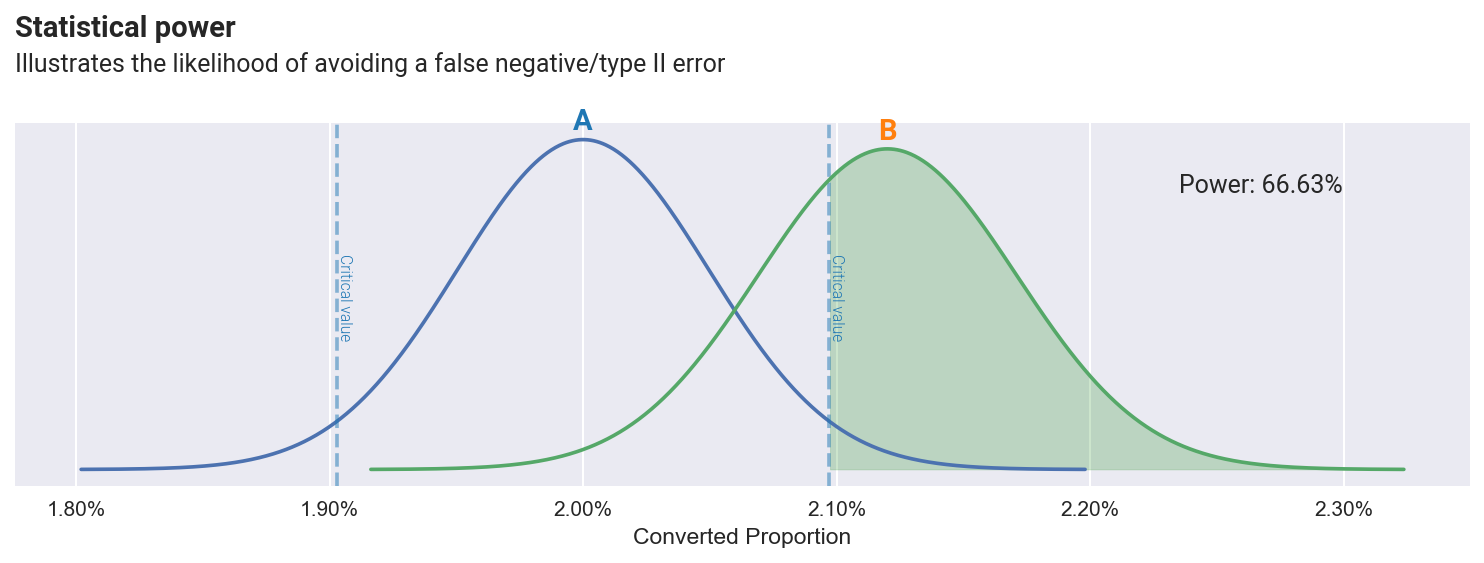

In [27]:
# Power plot
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)


xA = np.linspace(control_cr-4*control_se, control_cr+4*control_se, 1000)
yA = scs.norm(control_cr, control_se).pdf(xA)
ax.plot(xA, yA, label='A')
# ax.axvline(x=control_cr, c='red', alpha=0.5, linestyle='--')

if tail_direction == 'left':
    ax.axvline(
        x=control_cr+control_se*z_value_for_alpha,
        c='tab:blue', alpha=0.5, linestyle='--'
    )
    ax.text(
        control_cr+control_se*z_value_for_alpha,
        max(yA)*0.4,
        "Critical value",
        color='tab:blue',
        rotation=270,
        **roboto_small
    )
elif tail_direction == 'right':
    ax.axvline(
        x=control_cr-control_se*z_value_for_alpha,
        c='tab:blue', alpha=0.5, linestyle='--'
    )
    ax.text(
        control_cr-control_se*z_value_for_alpha,
        max(yA)*0.4,
        "Critical value",
        color='tab:blue',
        rotation=270,
        **roboto_small
    )
else:
    ax.axvline(
        x=control_cr-control_se*z_value_for_alpha,
        c='tab:blue', alpha=0.5, linestyle='--'
    )
    ax.text(
        control_cr-control_se*z_value_for_alpha,
        max(yA)*0.4,
        "Critical value",
        color='tab:blue',
        rotation=270,
        **roboto_small
    )

    ax.axvline(
        x=control_cr+control_se*z_value_for_alpha,
        c='tab:blue', alpha=0.5, linestyle='--'
    )
    ax.text(
        control_cr+control_se*z_value_for_alpha,
        max(yA)*0.4,
        "Critical value",
        color='tab:blue',
        rotation=270,
        **roboto_small
    )

ax.text(
    control_cr,
    max(yA)*1.03,
    "A",
    color='tab:blue',
    horizontalalignment='center',
    **roboto_bold
)

xB = np.linspace(variant_cr-4*variant_se, variant_cr+4*variant_se, 1000)
yB = scs.norm(variant_cr, variant_se).pdf(xB)
ax.plot(xB, yB, label='B')

ax.text(
    variant_cr,
    max(yB)*1.03,
    "B",
    color='tab:orange',
    horizontalalignment='center',
    **roboto_bold
)

if relative_difference > 0:
    ax.fill_between(
        xB, 0, yB,
        where=(xB > control_cr + control_se*z_value_for_alpha),
        color='green', alpha=0.2
    )
else:
    ax.fill_between(
        xB, 0, yB,
        where=(xB < control_cr - control_se*z_value_for_alpha),
        color='green', alpha=0.2
    )

ax.text(
    ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*0.8,
    ax.get_ylim()[1]*0.8,
    f"Power: {power:.2%}",
    horizontalalignment='left',
    **roboto
)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.xlabel('Converted Proportion')

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.25,
    'Statistical power',
    **roboto_title
)

ax.text(
    ax.get_xlim()[0],
    ax.get_ylim()[1]*1.15,
    "Illustrates the likelihood of avoiding a false negative/type II error",
    **roboto
)

sns.despine(left=True)
ax.get_yaxis().set_visible(False)
fig.tight_layout()

plt.show()